<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Analyse_Stationnarit%C3%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In [40]:
import sys
import pandas

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

# Méthodes permettant de vérifier la non stationnarité des séries temporelles

**1. Exemple de séries**

Commençons par charger notre série habituelle ...

In [41]:
# Fonction permettant de créer une tendance
def tendance(temps, pente=0):
    return pente * temps

# Fonction permettant de créer un motif
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

# Fonction permettant de créer une saisonnalité avec un motif
def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

# Création de la série temporelle
temps = np.arange(4 * 365)                # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
amplitude = 40                            # Amplitude de la la saisonnalité
niveau_bruit = 5                          # Niveau du bruit
offset = 10                               # Offset de la série

serie = offset + tendance(temps, 0.1) + saisonnalite(temps, periode=365, amplitude=amplitude) + bruit_blanc(temps,niveau_bruit,graine=40)

Téléchargeons maintenant d'autres exemples :

In [42]:
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/daily-total-female-births-in-cal.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/international-airline-passengers.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/shampoo-sales.csv"
!wget -q --no-check-certificate --content-disposition "https://raw.githubusercontent.com/AlexandreBourrieau/ML/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/data/Sunspots.csv"

In [61]:
!wget --no-check-certificate --content-disposition "https://drive.google.com/uc?export=download&id=1kd4IUUX0uFerQc9xP3mXFhTYA8YiEDhR"
!wget --no-check-certificate --content-disposition "https://drive.google.com/uc?export=download&id=1dEh3G7AnwhzJe91zsW-1vUOtQHCE-v36"
!wget --no-check-certificate --content-disposition "https://drive.google.com/uc?export=download&id=177g_DahQxZKr5AuS0llUuGE2pRoC5vdW"

--2021-04-08 18:22:13--  https://drive.google.com/uc?export=download&id=1kd4IUUX0uFerQc9xP3mXFhTYA8YiEDhR
Resolving drive.google.com (drive.google.com)... 172.217.204.102, 172.217.204.139, 172.217.204.101, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ciiq12mp48ug0e5o3i7j8pbemk920i69/1617906075000/04637559294651438089/*/1kd4IUUX0uFerQc9xP3mXFhTYA8YiEDhR?e=download [following]
--2021-04-08 18:22:15--  https://doc-0o-b8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ciiq12mp48ug0e5o3i7j8pbemk920i69/1617906075000/04637559294651438089/*/1kd4IUUX0uFerQc9xP3mXFhTYA8YiEDhR?e=download
Resolving doc-0o-b8-docs.googleusercontent.com (doc-0o-b8-docs.googleusercontent.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to doc-0o-b8-docs.googleusercontent.com (do

Text(0.5, 1.0, 'Notre série')

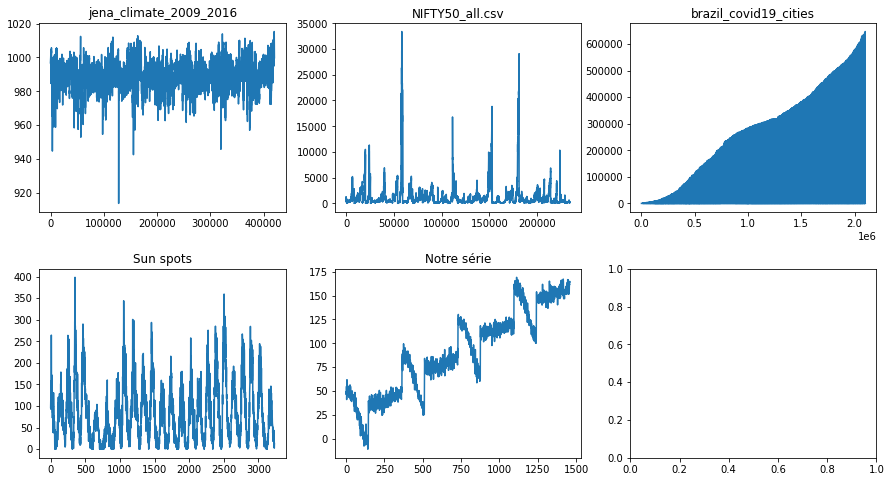

In [62]:
from pandas import Series
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Charge les données en mémoire
fichier1 = 'jena_climate_2009_2016.csv'
fichier2 = 'NIFTY50_all.csv'
fichier3 = 'brazil_covid19_cities.csv'
fichier4 = "Sunspots.csv"

serie1 = read_csv(fichier1, usecols=[1], engine='python', skipfooter=2)
serie2 = read_csv(fichier2, usecols=[4], engine='python', skipfooter=2)
serie3 = read_csv(fichier3, usecols=[4], engine='python', skipfooter=2)
serie4 = read_csv(fichier4, usecols=[2], engine='python', skipfooter=2)
serie5 = pandas.Series(serie)

data1 = serie1.values
data1 = data1.astype('float32')

data2 = serie2.values
data2 = data2.astype('float32')

data3 = serie3.values
data3 = data3.astype('float32')

data4 = serie4.values
data4 = data4.astype('float32')

data5 = serie.astype('float32')

# Affiche les données
f1, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 8))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

serie1.plot(subplots=True, ax=ax1, legend=False, sharex=False, sharey=False)
ax1.set_title('jena_climate_2009_2016')

serie2.plot(subplots=True, ax=ax2, legend=False, sharex=False, sharey=False)
ax2.set_title('NIFTY50_all.csv')

serie3.plot(subplots=True, ax=ax3, legend=False, sharex=False, sharey=False)
ax3.set_title('brazil_covid19_cities')

serie4.plot(subplots=True, ax=ax4, legend=False, sharex=False, sharey=False)
ax4.set_title('Sun spots')

serie5.plot(subplots=True, ax=ax5, legend=False, sharex=False, sharey=False)
ax5.set_title('Notre série')



Affichons maintenant les séries :

Text(0.5, 1.0, 'Notre série')

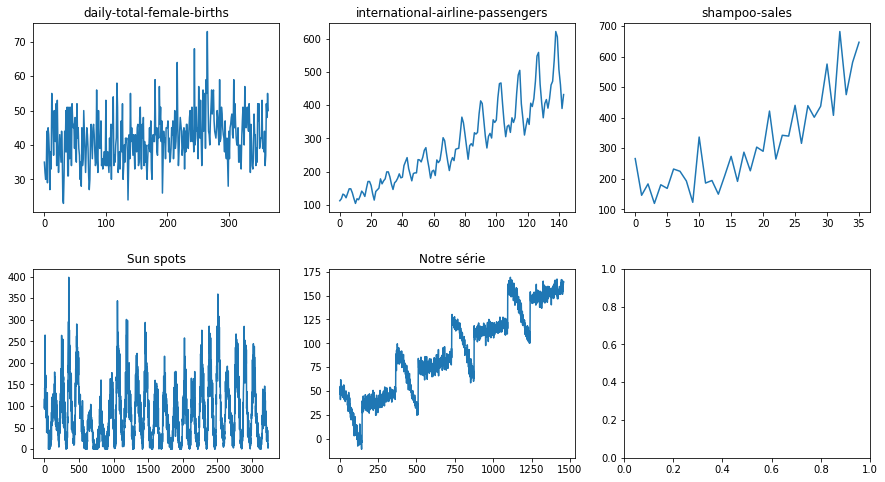

In [68]:
from pandas import Series
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Charge les données en mémoire
fichier1 = 'daily-total-female-births-in-cal.csv'
fichier2 = 'international-airline-passengers.csv'
fichier3 = 'shampoo-sales.csv'
fichier4 = "Sunspots.csv"

serie1 = read_csv(fichier1, usecols=[1], engine='python', skipfooter=2)
serie2 = read_csv(fichier2, usecols=[1], engine='python', skipfooter=2)
serie3 = read_csv(fichier3, usecols=[1], engine='python', skipfooter=2)
serie4 = read_csv(fichier4, usecols=[2], engine='python', skipfooter=2)
serie5 = pandas.Series(serie)

data1 = serie1.values
data1 = data1.astype('float32')

data2 = serie2.values
data2 = data2.astype('float32')

data3 = serie3.values
data3 = data3.astype('float32')

data4 = serie4.values
data4 = data4.astype('float32')

data5 = serie.astype('float32')

# Affiche les données
f1, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 8))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

serie1.plot(subplots=True, ax=ax1, legend=False, sharex=False, sharey=False)
ax1.set_title('daily-total-female-births')

serie2.plot(subplots=True, ax=ax2, legend=False, sharex=False, sharey=False)
ax2.set_title('international-airline-passengers')

serie3.plot(subplots=True, ax=ax3, legend=False, sharex=False, sharey=False)
ax3.set_title('shampoo-sales')

serie4.plot(subplots=True, ax=ax4, legend=False, sharex=False, sharey=False)
ax4.set_title('Sun spots')

serie5.plot(subplots=True, ax=ax5, legend=False, sharex=False, sharey=False)
ax5.set_title('Notre série')



**2. Vérification de l'aspect aléatoire des séries par Lag Plot**

Le but est ici d'afficher l'évolution de la série à l'instant (t+nt) en fonction de l'instant précédent : s(t+nt) en fonction de s(t).

Par exemple, si on affiche s(t+1) en fonction de s(t) on utilise un lag plot d'ordre 1.

Si un motif se dessine, cela signifie que la série n'est pas aléatoire. Si le motif qui se dessine est linéaire, cela suggère qu'il existe une autocorrelation.

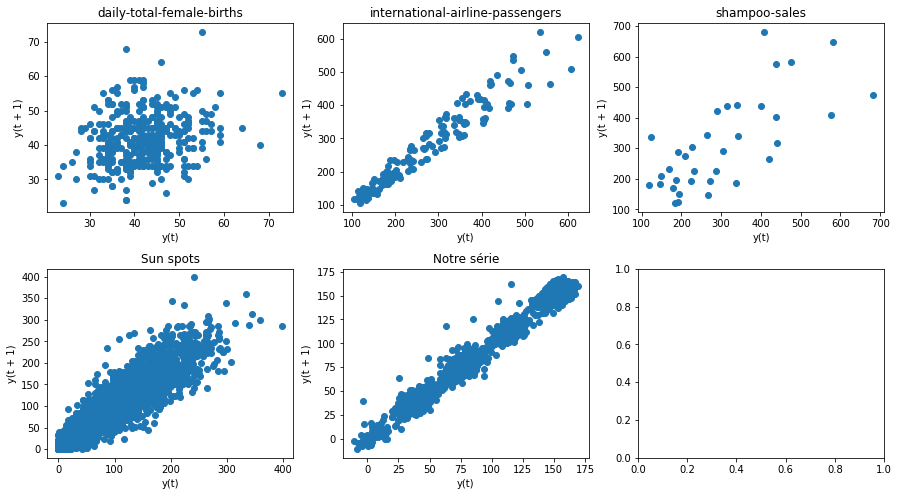

In [69]:
from pandas.plotting import lag_plot

f1, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 8))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

# Aléatoire
lag_plot(serie1, ax=ax1)
ax1.set_title('daily-total-female-births');

# Auto-corrélée
lag_plot(serie2, ax=ax2)
ax2.set_title('international-airline-passengers');

# Aléatoire avec un peu d'auto-correlation
lag_plot(serie3, ax=ax3)
ax3.set_title('shampoo-sales');


lag_plot(serie4, ax=ax4)
ax4.set_title('Sun spots');

# Auto-corrélée
lag_plot(serie5, ax=ax5)
ax5.set_title('Notre série');


plt.show()

**3. Vérification de l'aspect aléatoire des séries par auto-corrélation**

L'objectif est ici de calculer les autocorrélations pour différentes valeurs de décalage.
Si la série est aléatoire, alors le résultat devrait être proche de zéro. Sinon, certaines des autocorrélations seront très différentes de zéro.  
  
  Les lignes horizontales représentent les bandes de confiances à 95% du niveau critique de corrélation (99% pour les lignes en pointillés) : Les résultats de l'autocorrélation qui sont dans ces bandes nous disent qu'il y a 95% de chance que la série soit non corrélée pour la valeur de ce décalage.  
  Les séries les plus aléatoires vont donc être celles qui auront le plus de résultats à l'intérieur de ces bandes de confiance.

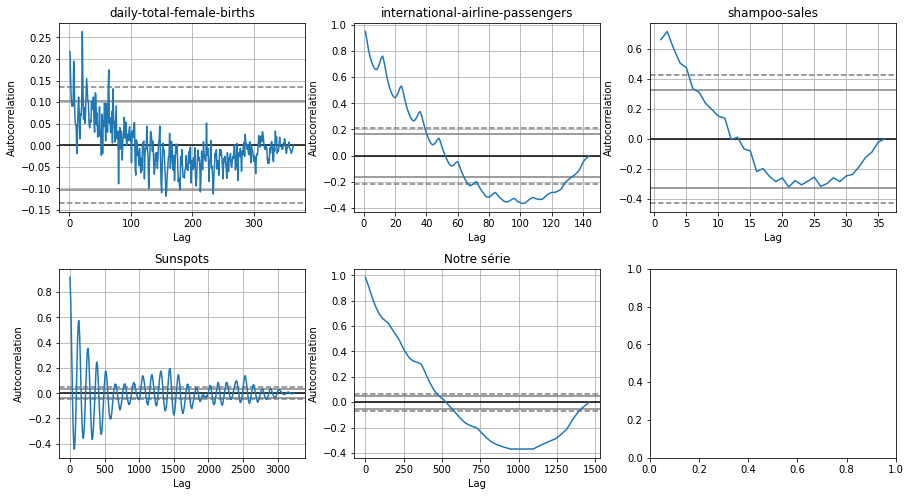

In [53]:
from pandas.plotting import autocorrelation_plot

f1, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 8))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

# Série très peu corrélée
autocorrelation_plot(serie1, ax=ax1)
ax1.set_title('daily-total-female-births');

# Série fortement corrélée
autocorrelation_plot(serie2, ax=ax2)
ax2.set_title('international-airline-passengers');

# Série très peu corrélée
autocorrelation_plot(serie3, ax=ax3)
ax3.set_title('shampoo-sales');

# Série un peu corrélée
autocorrelation_plot(serie4, ax=ax4)
ax4.set_title('Sunspots');

# Série fortement corrélée
autocorrelation_plot(serie5, ax=ax5)
ax5.set_title('Notre série');

plt.show()